# Introduction
Thanks for taking the time to review my final project for DTSA 5509! My project explores what makes NHL players stand out among their peers. With the recent and exciting NHL 4-Nations tournament occurring in place of a traditional All-Star Game, I wanted to know what exactly the players selected for these games do to stand out. NHL players already play in the most demanding and skilled hockey league in the world, how can some level up their game even further?  

To explore this idea I will use statistics data for each player in the league over a several year period. This feature set includes statistics on things like games played and shots on goal, to more advanced statistics like a measure named 'Corsi' (Corsi measures the total shots towards the net, regardless if they're on target or get blocked). I will then use All-Star Game selections as the target variable. I want to see if we can predict All-Star Game selections based on these yearly statistics; ultimately I want to use classification algorithms to gain these insights. 

My curiosity about this relationship inspired the project. However, I think that one possible application could be for players and their agents to use these models to focus on certain statistics shown to help All-Star Game selection. Some players contracts contain incentives and bonuses for making these select teams. To this end, I intend to discover what features contribute the most to predicting the target variable.

This project will use several machine learning techniques for both feature selection and classification-- XGBoost, Random Forest, and Lasso Logistic Regression.

## Data Sources
### Player Stats
I downloaded the player statistics data from a website called MoneyPuck (https://moneypuck.com/). A tremendous hockey data resource, the website provides free to use data including player data, team data, play data, and other tables. They also provide some in-house built analytics and dashboards. I highly recommend the site to anyone looking for a robust source of NHL analytics data.
  
For this project we need player statistics for the features of our models. I downloaded csv files for the 2019-2023 NHL seasons for this purpose; you can find these downloads under the appropriate year here: https://moneypuck.com/data.htm. I then uploaded the csv files to Kaggle. From Kaggle's upload utility I read the files into the notebook for analysis.  Below I provide a table of the column composition and total rows:
| Column Type              | Number of Columns |
|----------------------|------|
| String/Categorical      | 3   |
| Integer | 4      |
| Float | 147      |
| **Total Rows**      | **23,370**              |

The 'Positon' categorical variable should be the only categorical variable of use in prediction. Most of the important features will come from the float columns, data like goals, assists, and time on ice. I concatenated the season specific csv files into one larger data frame. I cleaned and analyzed this concatenated frame then merged it with the target variables for modeling.
  
### All-Star Rosters
For the target variable, we need to know what players made the All-Star Game in a given year. I used Wikipedia to populate these All-Star Rosters. In years that included fan voting, I excluded any player selections coming from that source. The reason being that fan votes could favor popularity over statistic driven selection. I copied the player lists from the All-Star Game rosters into an Excel file and uploaded that to Kaggle as well. The All-Star rosters came from these Wikipedia pages:
  
https://en.wikipedia.org/wiki/2023_National_Hockey_League_All-Star_Game  
https://en.wikipedia.org/wiki/2022_National_Hockey_League_All-Star_Game  
https://en.wikipedia.org/wiki/2020_National_Hockey_League_All-Star_Game  
https://en.wikipedia.org/wiki/2019_National_Hockey_League_All-Star_Game  
  
Because I copied this data into Excel from lists in Wikipedia, some cleaning needed to be done before even bringing the data into the notebook. I removed images of player nationality flags and jersey numbers from the tables. The imported table contained an integer column for year, and a string column for player name and position. 
  
Additionally, as you can see above, no All-Star game occurred in 2021 due to the Covid-19 pandemic; I cleaned the 2021-season stats from the statistics data frame. 

Please see References for more detailed citation.



In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
# read in files downloaded from MoneyPuck.com

df_2019 = pd.read_csv('/kaggle/input/player-stats/skaters.csv')
df_2020 = pd.read_csv('/kaggle/input/player-stats/skaters-611a6741.csv')
df_2021 = pd.read_csv('/kaggle/input/player-stats/skaters-99ba5ff8.csv')
df_2022 = pd.read_csv('/kaggle/input/player-stats/skaters-24d7e597.csv')
df_2023 = pd.read_csv('/kaggle/input/player-stats/skaters-9ba44874.csv')

# read in All-Star Roster excel

df_all_stars = pd.read_excel('/kaggle/input/all-star-rosters/AllStarList.xlsx')


In [71]:
# put stats dfs into a list
df_list = [df_2019, df_2020, df_2021, df_2022, df_2023]

# concatenate all the stats data frames
df_stats = pd.concat(df_list, ignore_index=True)

In [72]:
# get info on the stats data frame
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23370 entries, 0 to 23369
Columns: 154 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(3), object(4)
memory usage: 27.5+ MB


## Data Cleaning
### Target Cleaning
As mentioned in the Data Sources section, I did some basic cleaning in Excel before loading the data into Kaggle and this notebook. Further cleaning required removing players playing goalie, and altering some player names so they would merge onto the statistics frame. I removed the goalies because the statistics frame only contains data for skaters; players who don't play goalie. I also noticed that no All-Star game occurred in 2021, so those rows in the statistics frame will need to be removed.

### Feature Cleaning
I first cleaned the names where necessary to match with the target frame. I also removed the season year 2021 statistics because no All-Star game occurred that year. After reviewing the statistics table details and doing some initial exploratory data analysis I discovered what additional cleaning was necessary.

The feature set contains a variable for situation, this indicates the penalty status of the game. Players playing with no-active penalty show as '5on5,' players on the power play show as '5on4,' and players on the penalty kill show as '4on5.' The data contains 'other' and 'all' situations but I will remove them; the 'other' to reduce noise in the data as those situations occur more rarely, and 'all' becasue that would introduce redundant rows. 


In [73]:
# clean all-star frame

all_stars_cl = df_all_stars.copy()

# remove all goalies
all_stars_cl = all_stars_cl[all_stars_cl['Position'] != 'G']

# some players names' don't match in the features and target frames

# T. J. Oshie's name doesn't match in the two data frames. Change name in all-star frame from T. J. Oshie to T.J. Oshie
all_stars_cl['name'] = all_stars_cl['name'].str.replace('T. J. Oshie', 'T.J. Oshie')

# Troy Terry~ has a tilda, remove the extra character
all_stars_cl['name'] = all_stars_cl['name'].str.replace('Troy Terry~', 'Troy Terry')

# change all-star columns to season, name, position
all_stars_cl.columns = ['season', 'name', 'position']


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


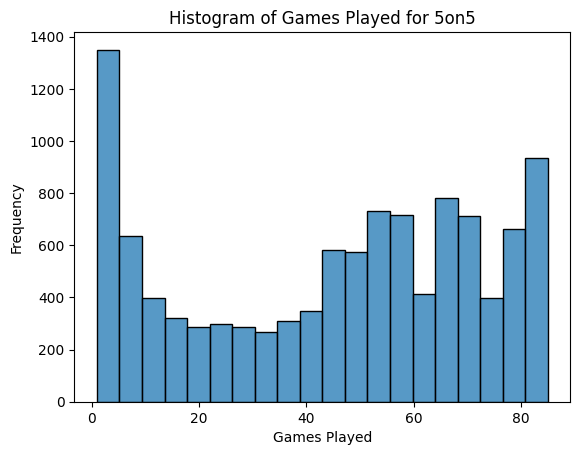

In [74]:
# clean stats frame

stats_cl = df_stats.copy()

# one player's names doesn't match in the features and target frames

# Mitchell Marner's name doesn't match in the two data frames. It's both Mitch and Mitchell in the stats frame for different years; change all to Mitch
stats_cl['name'] = stats_cl['name'].str.replace('Mitchell Marner', 'Mitch Marner')

# remove 2021 season
stats_cl = stats_cl[stats_cl['season'] != 2021]

# remove 'other' and all 'rows' from situation column
stats_cl = stats_cl[stats_cl['situation'].str.contains('5')]

# check games played and minutes histograms for 5on5
sns.histplot(data=stats_cl, x=stats_cl['games_played'], bins=20, kde=False)
# Add title and labels
plt.title('Histogram of Games Played for 5on5')
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.show()



Text(0.5, 0, 'Games Played')

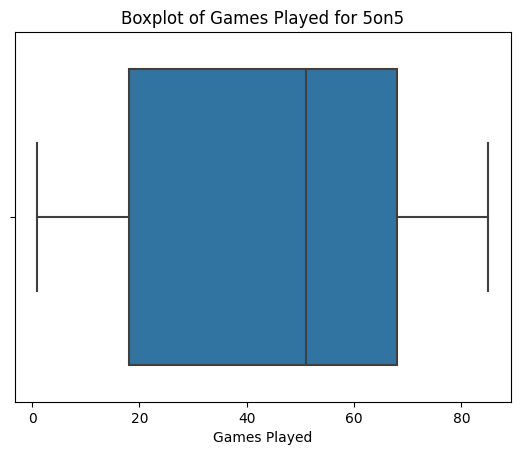

In [75]:
# boxplot of same data
sns.boxplot(data=stats_cl, x=stats_cl['games_played'])
# Add title and labels
plt.title('Boxplot of Games Played for 5on5')
plt.xlabel('Games Played')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


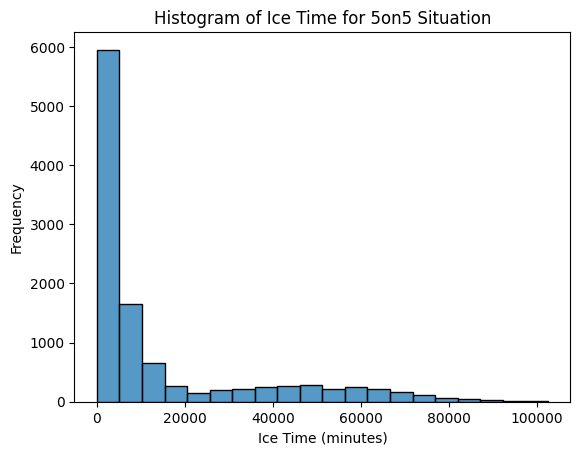

In [76]:
# plot the histogram
sns.histplot(data=stats_cl, x=stats_cl['icetime'], bins=20, kde=False)

# Add title and labels
plt.title('Histogram of Ice Time for 5on5 Situation')
plt.xlabel('Ice Time (minutes)')
plt.ylabel('Frequency')
plt.show()


### Feature Cleaning (Cont.)
Looking at the distribution of games played, as well as the boxplot for that same variable, we see that a significant amount of players don't play a full 82 game season. This could be because of injuries, or less skilled players coming into the league on two-way contracts (players splitting their time between the minor leagues and the NHL). It also inflates the ice time variable at the lower end of the range. Therefore I removed any rows for players playing less than 20 games (anything below the first quartile), as injuries or players with only borderline NHL skill will skew our statistics downward. Removing these players also comes with the added benefit of improving the balance of our target class.

This dataset contains a lot of columns, many of which being collinear. Some of the collinearity comes from the fact that one column gets derived from other columns. For example, expected goals percentage gets calculated as follows: On Ice xGoals For / (On Ice xGoals For + On Ice xGoals Against). I removed columns that get derived directly from other columns. I also removed any columns that I don't think contribute to our task here, such as how many shifts ended with a player changing on the fly (while interesting in some contexts, not relevant here).
  
Our next cleaning step involves dealing with the special teams, 5on4 and 4on5 situations. Our dataframe contains three rows per player per season. This makes doing analysis difficult, to resolve this I pivoted the 5on4 and 4on5 situations to create new rows. To keep the statistics frame from becoming too wide, I will remove any pivoted columns that I think irrelevant to those situations according to my domain knowledge. I added the suffix '_pp' to the 5on4 rows and '_sh' to the 4on5 rows to represent power plays and short handed stats respectively.  

After making these changes I examined the histograms of ice time for the three situations again. You will see below that these ice time distributions seem much more appropriate for our analysis. The special teams still look zero inflated but we expect that to some degree as only the top players get time on these units.


In [77]:
# remove games played less than 40
stats_cl = stats_cl[stats_cl['games_played'] >= 20]

# remove columns list
remove_ls = [
    'shifts'          # probably collinear with ice time
    , 'gameScore'    
    , 'onIce_xGoalsPercentage'
    , 'offIce_xGoalsPercentage'
    , 'offIce_corsiPercentage'   # more interested in on ice stats
    , 'offIce_fenwickPercentage'   # more interested in on ice stats
    , 'iceTimeRank'
# expected stats come from another model and don't want to layer models here
    , 'I_F_xOnGoal'   
    , 'I_F_xGoals'
    , 'I_F_xFreeze'
    , 'I_F_xPlayStopped'
    , 'I_F_xPlayContinuedOutsideZone'
    , 'I_F_flurryAdjustedxGoals'
    , 'I_F_scoreVenueAdjustedxGoals'
    , 'I_F_flurryScoreVenueAdjustedxGoals'

    , 'I_F_missedShots'   # already measuring total shots
    , 'I_F_blockedShotAttempts'
    , 'I_F_points'   # already counting goas and assists so this would be redundant
    , 'I_F_reboundGoals'
    , 'I_F_freeze'
    , 'I_F_playStopped'
    , 'I_F_playContinuedInZone'
    , 'I_F_playContinuedOutsideZone'
    , 'I_F_savedShotsOnGoal'
    , 'I_F_savedUnblockedShotAttempts'
    , 'I_F_penalityMinutes'
    , 'penalties'   # penalty minutes will be a better predictor because it accounts for penalty severity
    , 'I_F_faceOffsWon'   # only relevant for centers

# another set of modeled variables
    , 'I_F_lowDangerShots'
    , 'I_F_mediumDangerShots'
    , 'I_F_highDangerShots'
    , 'I_F_lowDangerxGoals'
    , 'I_F_mediumDangerxGoals'
    , 'I_F_highDangerxGoals'
    , 'I_F_lowDangerGoals'
    , 'I_F_mediumDangerGoals'
    , 'I_F_highDangerGoals'
    , 'I_F_scoreAdjustedShotsAttempts'
    , 'I_F_unblockedShotAttempts'
    , 'I_F_scoreAdjustedUnblockedShotAttempts'
    , 'I_F_xGoalsFromxReboundsOfShots'
    , 'I_F_xGoalsFromActualReboundsOfShots'
    , 'I_F_reboundxGoals'
    , 'I_F_xGoals_with_earned_rebounds'
    , 'I_F_xGoals_with_earned_rebounds_scoreAdjusted'
    , 'I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted'

# shift data will probably be collinear with time on ice
    , 'I_F_shifts'
    , 'I_F_oZoneShiftStarts'
    , 'I_F_dZoneShiftStarts'
    , 'I_F_neutralZoneShiftStarts'
    , 'I_F_flyShiftStarts'
    , 'I_F_oZoneShiftEnds'
    , 'I_F_dZoneShiftEnds'
    , 'I_F_neutralZoneShiftEnds'
    , 'I_F_flyShiftEnds'

    , 'faceoffsWon'   # too position-centric
    , 'faceoffsLost'   # too position-centric
    , 'timeOnBench'

    , 'penaltiesDrawn'   # using penalty minutes drawn instead

# removing these for same reasons as the non-on-ice versions above
    , 'OnIce_F_xOnGoal'
    , 'OnIce_F_xGoals'
    , 'OnIce_F_flurryAdjustedxGoals'
    , 'OnIce_F_scoreVenueAdjustedxGoals'
    , 'OnIce_F_flurryScoreVenueAdjustedxGoals'
    , 'OnIce_F_shotsOnGoal'
    , 'OnIce_F_missedShots'
    , 'OnIce_F_blockedShotAttempts'
    , 'OnIce_F_shotAttempts'
    , 'OnIce_F_goals'
    , 'OnIce_F_rebounds'
    , 'OnIce_F_reboundGoals'
    , 'OnIce_F_lowDangerShots'
    , 'OnIce_F_mediumDangerShots'
    , 'OnIce_F_highDangerShots'
    , 'OnIce_F_lowDangerxGoals'
    , 'OnIce_F_mediumDangerxGoals'
    , 'OnIce_F_highDangerxGoals'
    , 'OnIce_F_lowDangerGoals'
    , 'OnIce_F_mediumDangerGoals'
    , 'OnIce_F_highDangerGoals'
    , 'OnIce_F_scoreAdjustedShotsAttempts'
    , 'OnIce_F_unblockedShotAttempts'
    , 'OnIce_F_scoreAdjustedUnblockedShotAttempts'
    , 'OnIce_F_xGoalsFromxReboundsOfShots'
    , 'OnIce_F_xGoalsFromActualReboundsOfShots'
    , 'OnIce_F_reboundxGoals'
    , 'OnIce_F_xGoals_with_earned_rebounds'
    , 'OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted'
    , 'OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted'
    , 'OnIce_A_xOnGoal'
    , 'OnIce_A_xGoals'
    , 'OnIce_A_flurryAdjustedxGoals'
    , 'OnIce_A_scoreVenueAdjustedxGoals'
    , 'OnIce_A_flurryScoreVenueAdjustedxGoals'
    , 'OnIce_A_shotsOnGoal'
    , 'OnIce_A_missedShots'
    , 'OnIce_A_blockedShotAttempts'
    , 'OnIce_A_rebounds'
    , 'OnIce_A_reboundGoals'
    , 'OnIce_A_lowDangerShots'
    , 'OnIce_A_mediumDangerShots'
    , 'OnIce_A_highDangerShots'
    , 'OnIce_A_lowDangerxGoals'
    , 'OnIce_A_mediumDangerxGoals'
    , 'OnIce_A_highDangerxGoals'
    , 'OnIce_A_lowDangerGoals'
    , 'OnIce_A_mediumDangerGoals'
    , 'OnIce_A_highDangerGoals'
    , 'OnIce_A_scoreAdjustedShotsAttempts'
    , 'OnIce_A_unblockedShotAttempts'
    , 'OnIce_A_scoreAdjustedUnblockedShotAttempts'
    , 'OnIce_A_xGoalsFromxReboundsOfShots'
    , 'OnIce_A_xGoalsFromActualReboundsOfShots'
    , 'OnIce_A_reboundxGoals'
    , 'OnIce_A_xGoals_with_earned_rebounds'
    , 'OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted'
    , 'OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted'
    , 'OffIce_F_xGoals'
    , 'OffIce_A_xGoals'
    , 'OffIce_F_shotAttempts'
    , 'OffIce_A_shotAttempts'
    , 'xGoalsForAfterShifts'
    , 'xGoalsAgainstAfterShifts'
    , 'corsiForAfterShifts'
    , 'corsiAgainstAfterShifts'
    , 'fenwickForAfterShifts'
    , 'fenwickAgainstAfterShifts'
]

# remove the unneeded columns
stats_cl = stats_cl.drop(columns = remove_ls)

# create a full strength frame to base the merges on, situation == 5on5
full_strength = stats_cl[stats_cl['situation'] == '5on5']
full_strength = full_strength.drop(columns = ['situation'])

# merge the special teams rows to new columns with 'power_play' and 'penalty_kill' in front of the new variables
merge_on = ['playerId', 'team', 'season', 'name', 'position', 'games_played']

# create a power play frame
power_play = stats_cl[stats_cl['situation'] == '5on4']
power_play = power_play.drop(columns = ['situation'])

# merge power play frame as new columns
pp_merge = pd.merge(
    full_strength
    , power_play
    , how = 'left'
    , on = merge_on
    , suffixes=('', '_pp')  # Add a suffix to distinguish new columns as power play
)

# create short handed frame; changing the nominclature to short handed so we can use sh instead of pk, don't want to confuse pp and pk
short_handed = stats_cl[stats_cl['situation'] == '4on5']   
short_handed = short_handed.drop(columns = ['situation'])

sh_merge = pd.merge(
    pp_merge
    , short_handed
    , how = 'left'
    , on = merge_on
    , suffixes=('', '_sh')  # Add a suffix to distinguish new columns as power play
)

# rename cleaned frame 'stats'
stats = sh_merge.copy()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


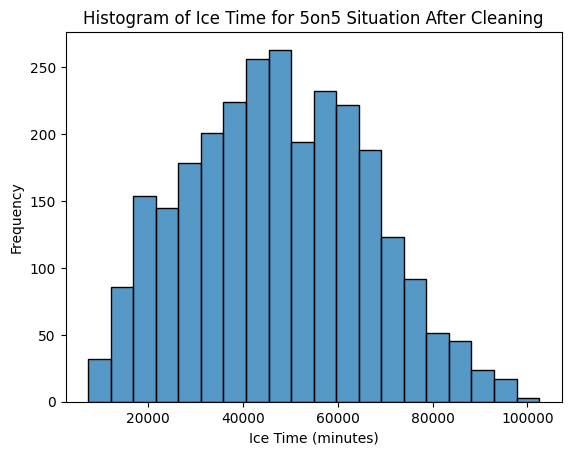

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


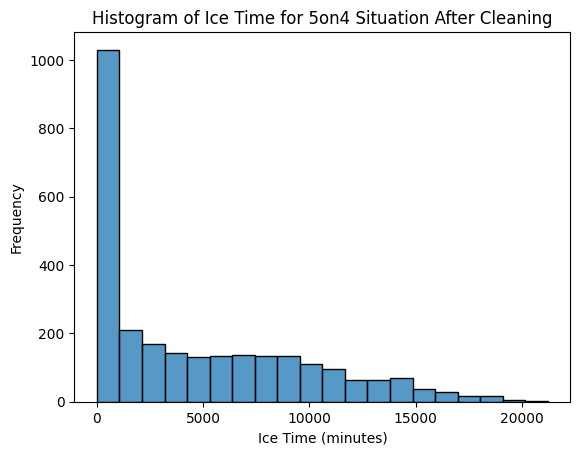

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


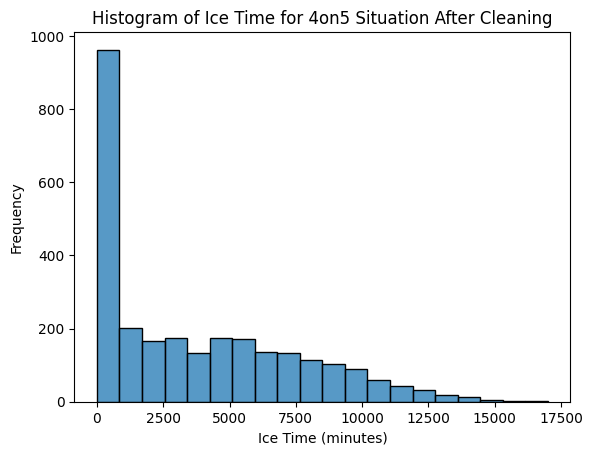

In [78]:
# check histogram of time on ice after cleaning
hist_df = stats.copy()
# plot the 5on5 histogram
sns.histplot(data= hist_df, x = hist_df['icetime'], bins=20, kde=False)

# Add title and labels
plt.title('Histogram of Ice Time for 5on5 Situation After Cleaning')
plt.xlabel('Ice Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# plot the 5on4 histogram
sns.histplot(data= hist_df, x = hist_df['icetime_pp'], bins=20, kde=False)

# Add title and labels
plt.title('Histogram of Ice Time for 5on4 Situation After Cleaning')
plt.xlabel('Ice Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# plot the 4on5 histogram
sns.histplot(data= hist_df, x = hist_df['icetime_sh'], bins=20, kde=False)

# Add title and labels
plt.title('Histogram of Ice Time for 4on5 Situation After Cleaning')
plt.xlabel('Ice Time (minutes)')
plt.ylabel('Frequency')
plt.show()


In [79]:
# change 

# our last cleaning step is to join on the target variables

# first I check to see that all targets have relevant rows

target_merge_check = pd.merge(
    all_stars_cl
    , stats
    , how = 'left'
    , on = ['name', 'season']
)

#target_merge_check[target_merge_check['playerId'].isna()]

# add an int 1 to the all star frame
all_stars_cl['target'] = 1

# merge the all star frame onto the stats frame
print(stats.shape)
df = pd.merge(
    stats
    , all_stars_cl[['season', 'name', 'target']]   # only want the name and season from the target
    , how = 'left'
    , on = ['season', 'name']
)
print(df.shape)
df.head()

# replace NaN with 0 and make sure they're ints
df['target'] = df['target'].fillna(0).astype(int)

df.info()

(2730, 66)
(2730, 67)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   playerId                     2730 non-null   int64  
 1   season                       2730 non-null   int64  
 2   name                         2730 non-null   object 
 3   team                         2730 non-null   object 
 4   position                     2730 non-null   object 
 5   games_played                 2730 non-null   int64  
 6   icetime                      2730 non-null   float64
 7   onIce_corsiPercentage        2730 non-null   float64
 8   onIce_fenwickPercentage      2730 non-null   float64
 9   I_F_xRebounds                2730 non-null   float64
 10  I_F_xPlayContinuedInZone     2730 non-null   float64
 11  I_F_primaryAssists           2730 non-null   float64
 12  I_F_secondaryAssists         2730 non-null   float64
 

### Cleaning Summary
After removing rows for players with limited games played in, and creating new columns for the special teams units, we can move on with our exploratory data analysis and predictive modeling. One interesting result from the data cleaning-- I found that three players made the All Star Game rosters with fewer than 20 games played in the season. All three players played in fewer than 13 games! I decided to drop these players from the data because of this. In the cell above you can see the table details, and I created a summary of the table we arrive at below:

| Column Type              | Number of Columns |
|----------------------|------|
| String/Categorical      | 3   |
| Integer | 4      |
| Float | 60      |
| **Total Rows**      | **2,730**              |

## Exploratory Data Analysis (EDA)
### Target Distribution
I first want to review the target class. We know roughly what to expect here, but let's visualize it to make sure.

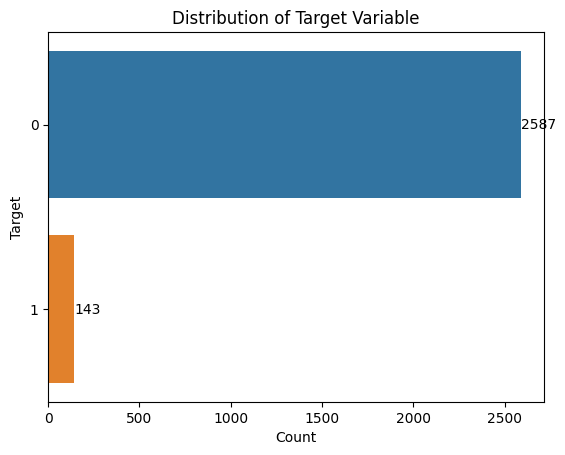

In [80]:
# target bar chart
ax = sns.countplot(data=df, y='target')

# Add count labels to each bar
for container in ax.containers:
    ax.bar_label(container)  # Automatically labels bars with counts

# Add title and labels
plt.title('Distribution of Target Variable')
plt.ylabel('Target')
plt.xlabel('Count')

# Show the plot
plt.show()

We see that about 1 in 20 players makes the All-Star Rosters. This is definitely an imbalanced class but we were expecting that. No need for concern here. 

### Multi-Collinearity
Next I decided to check for collinearity between our features. The data contains lots of features so I will separate this step into chunks. I will also select subsets of columns where I expect to see some collinearity. First I will look at even strength statistics, then special teams. If we find multicollinearity, then we will need to carefully select features as they can cause problems for linear models, tree based models, and boosting models.

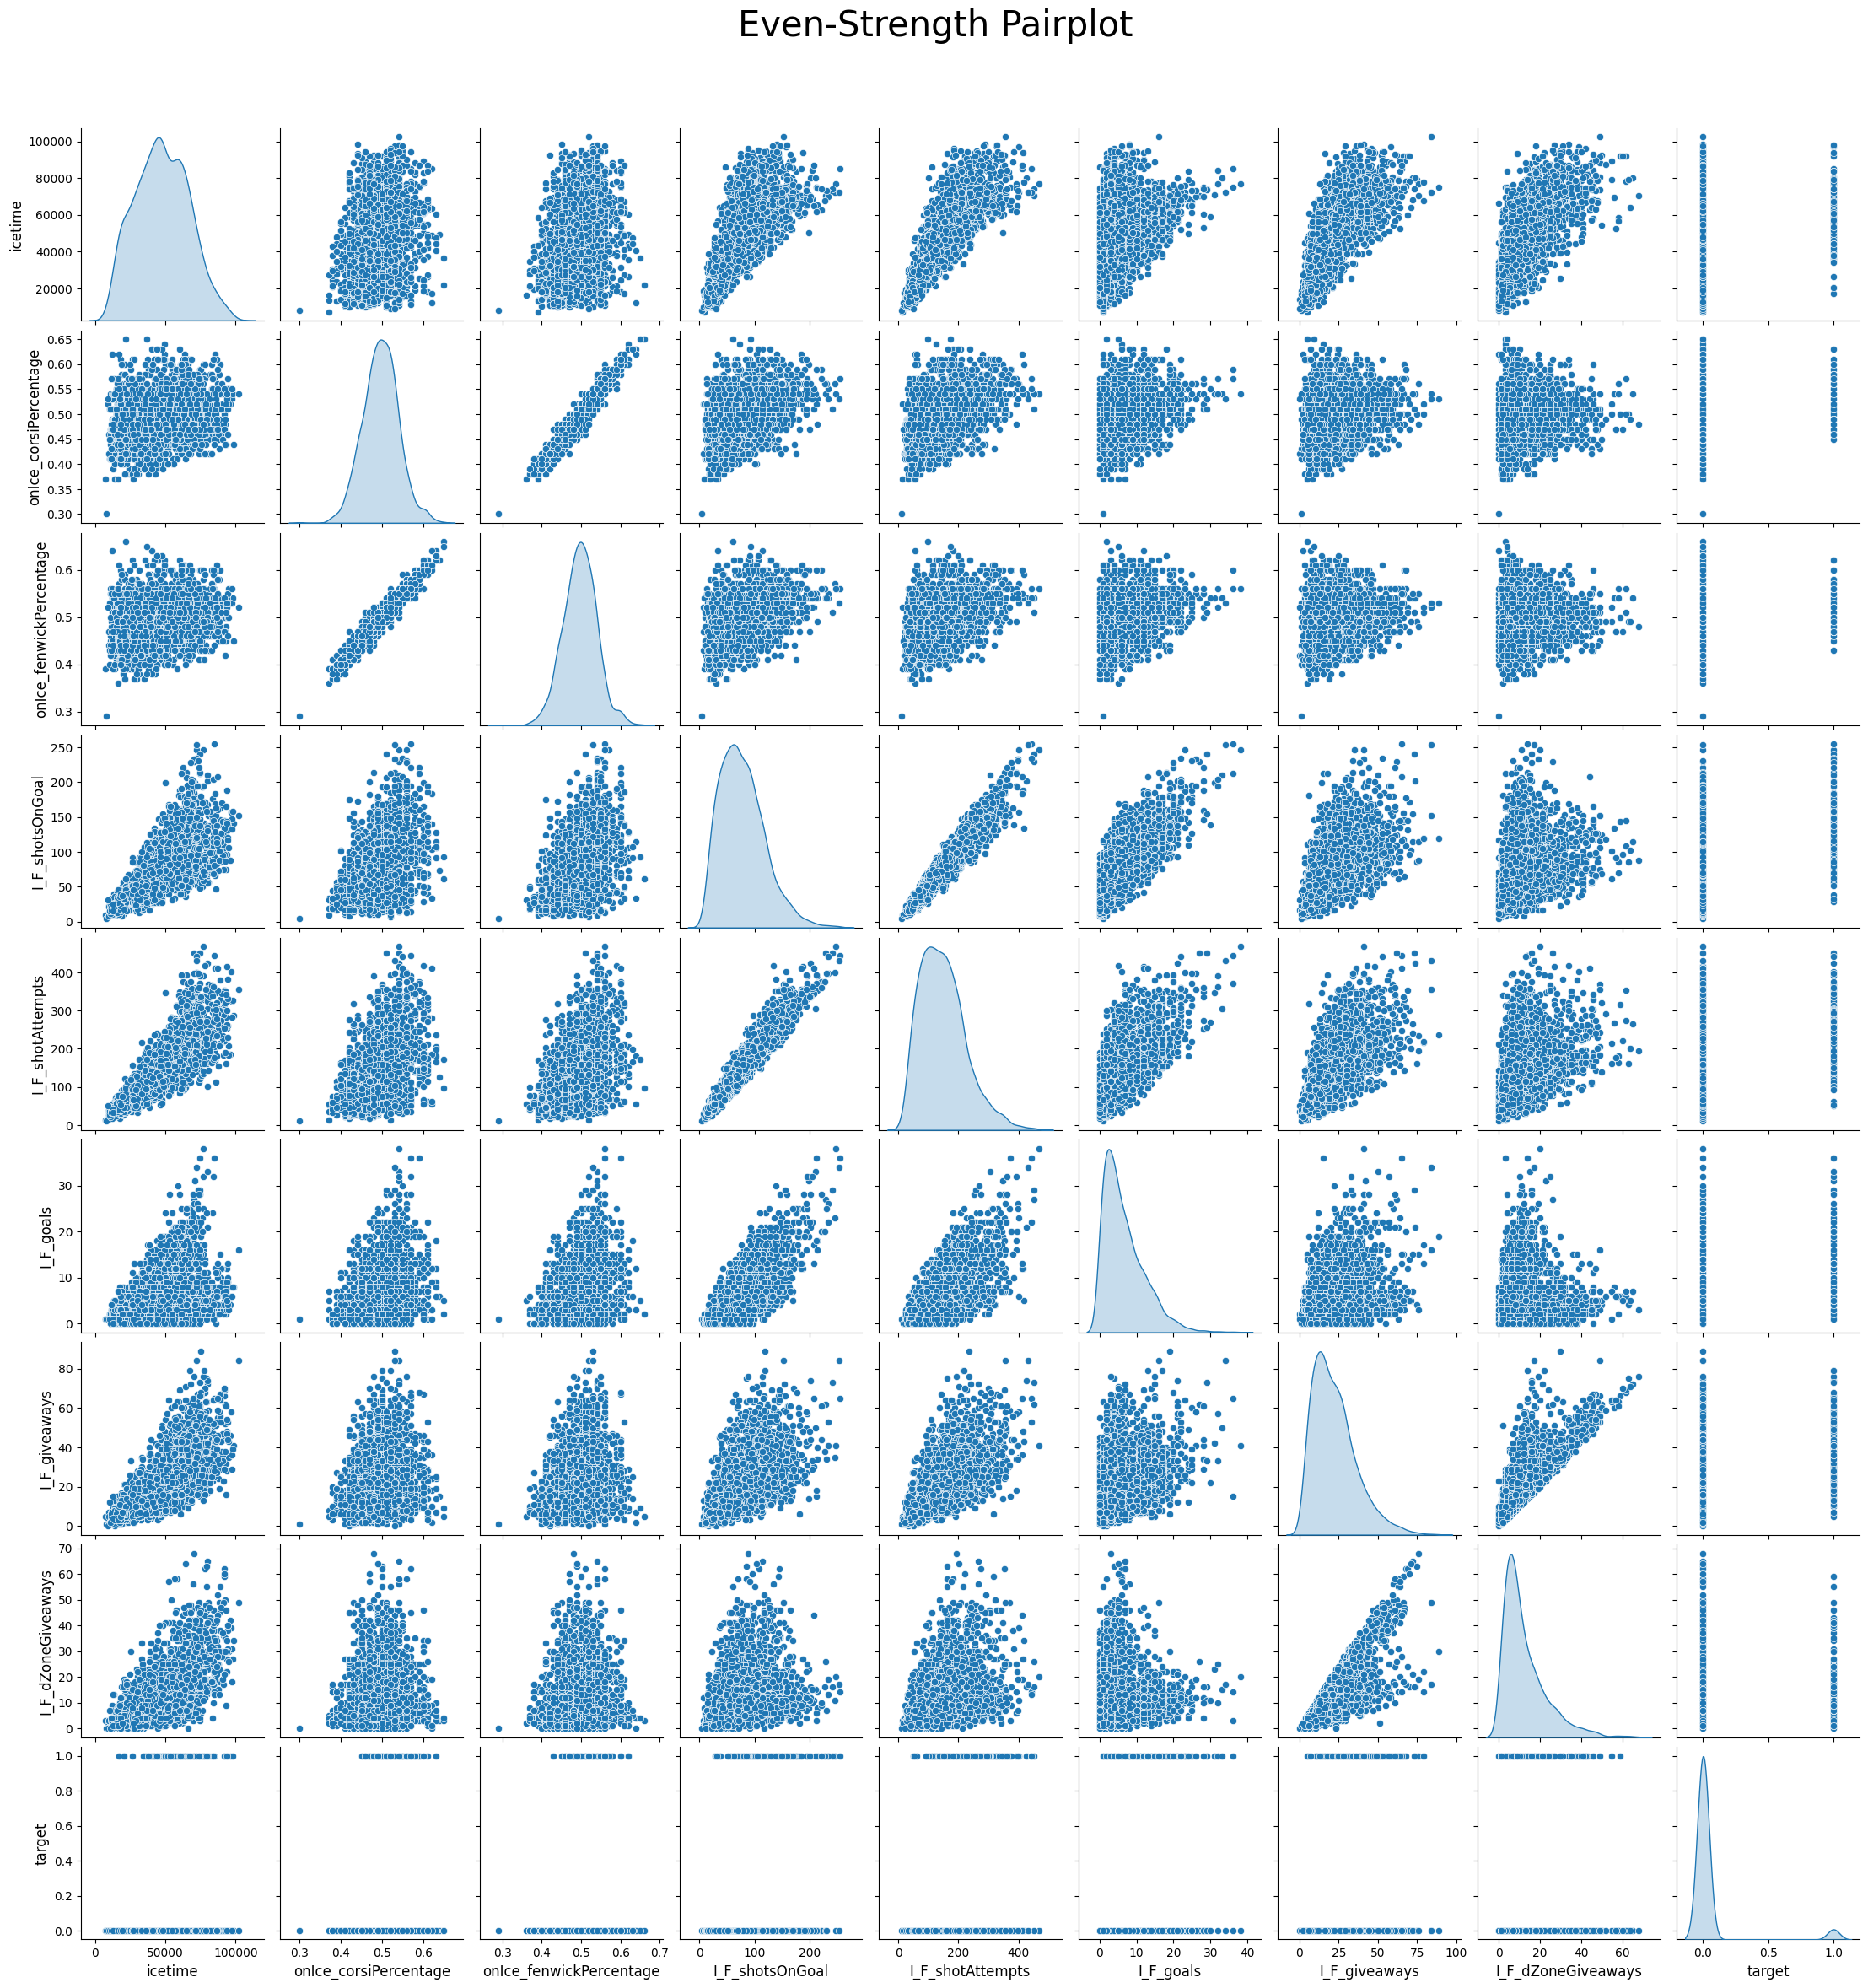

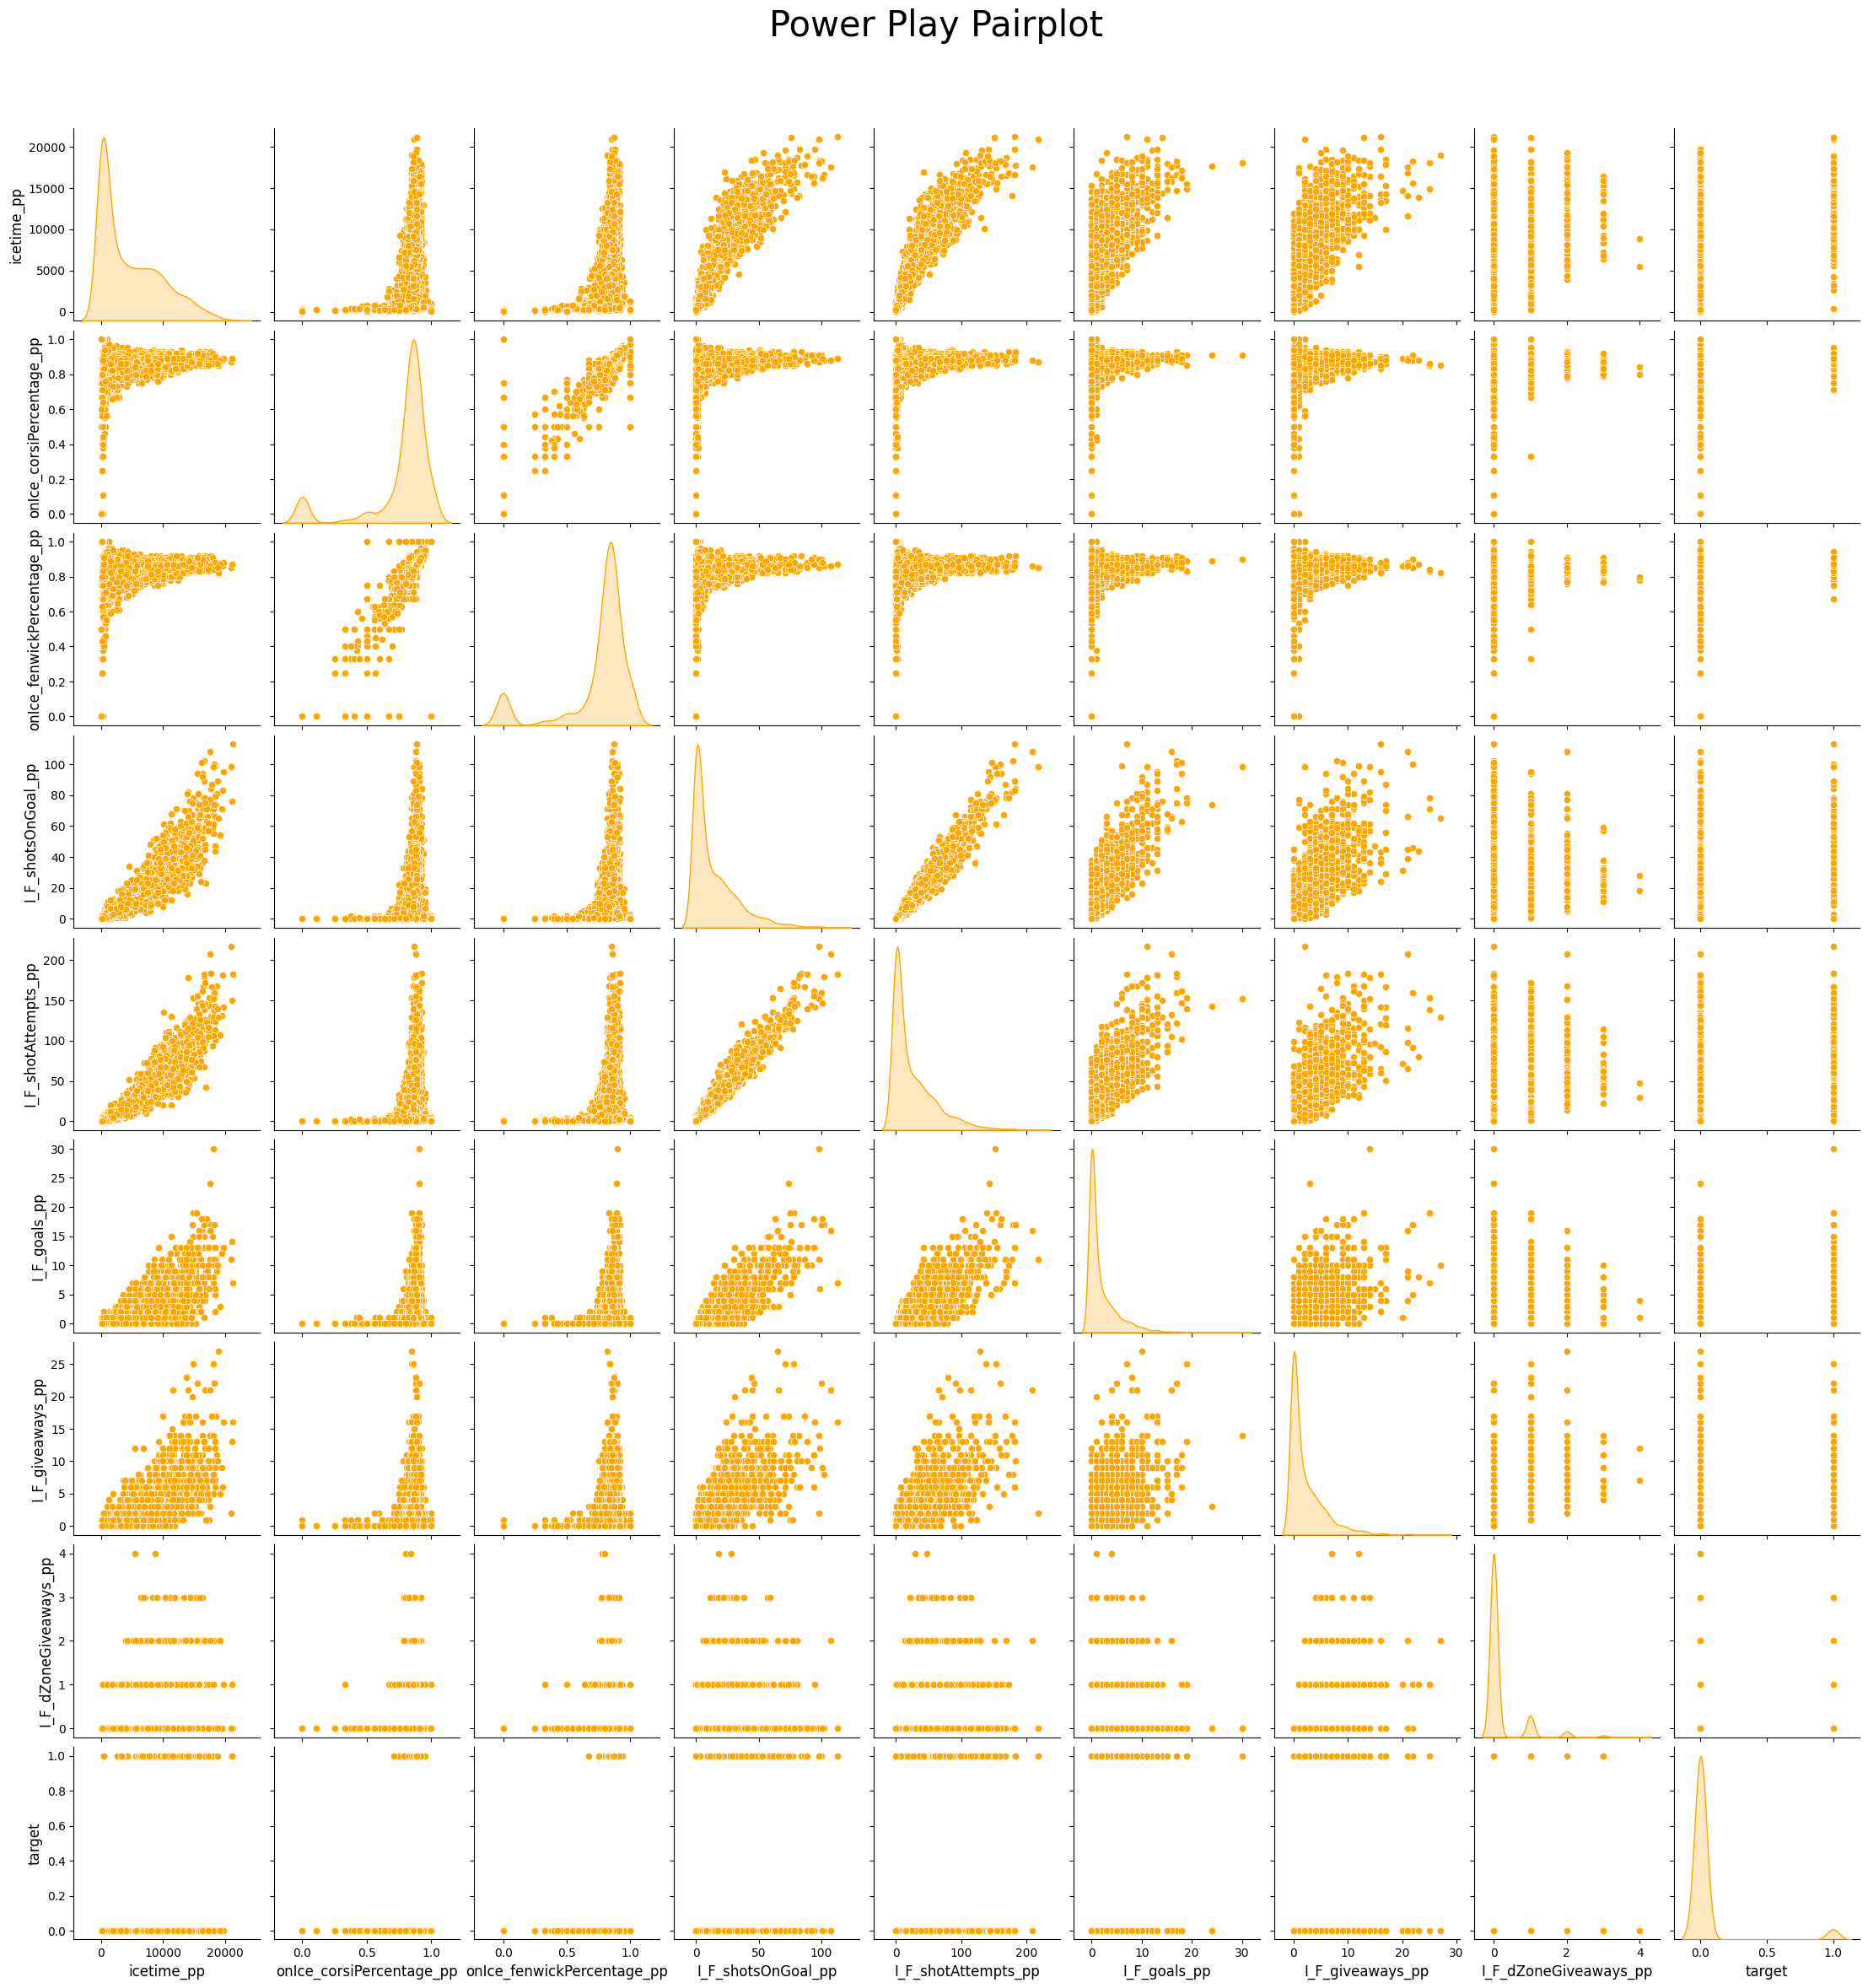

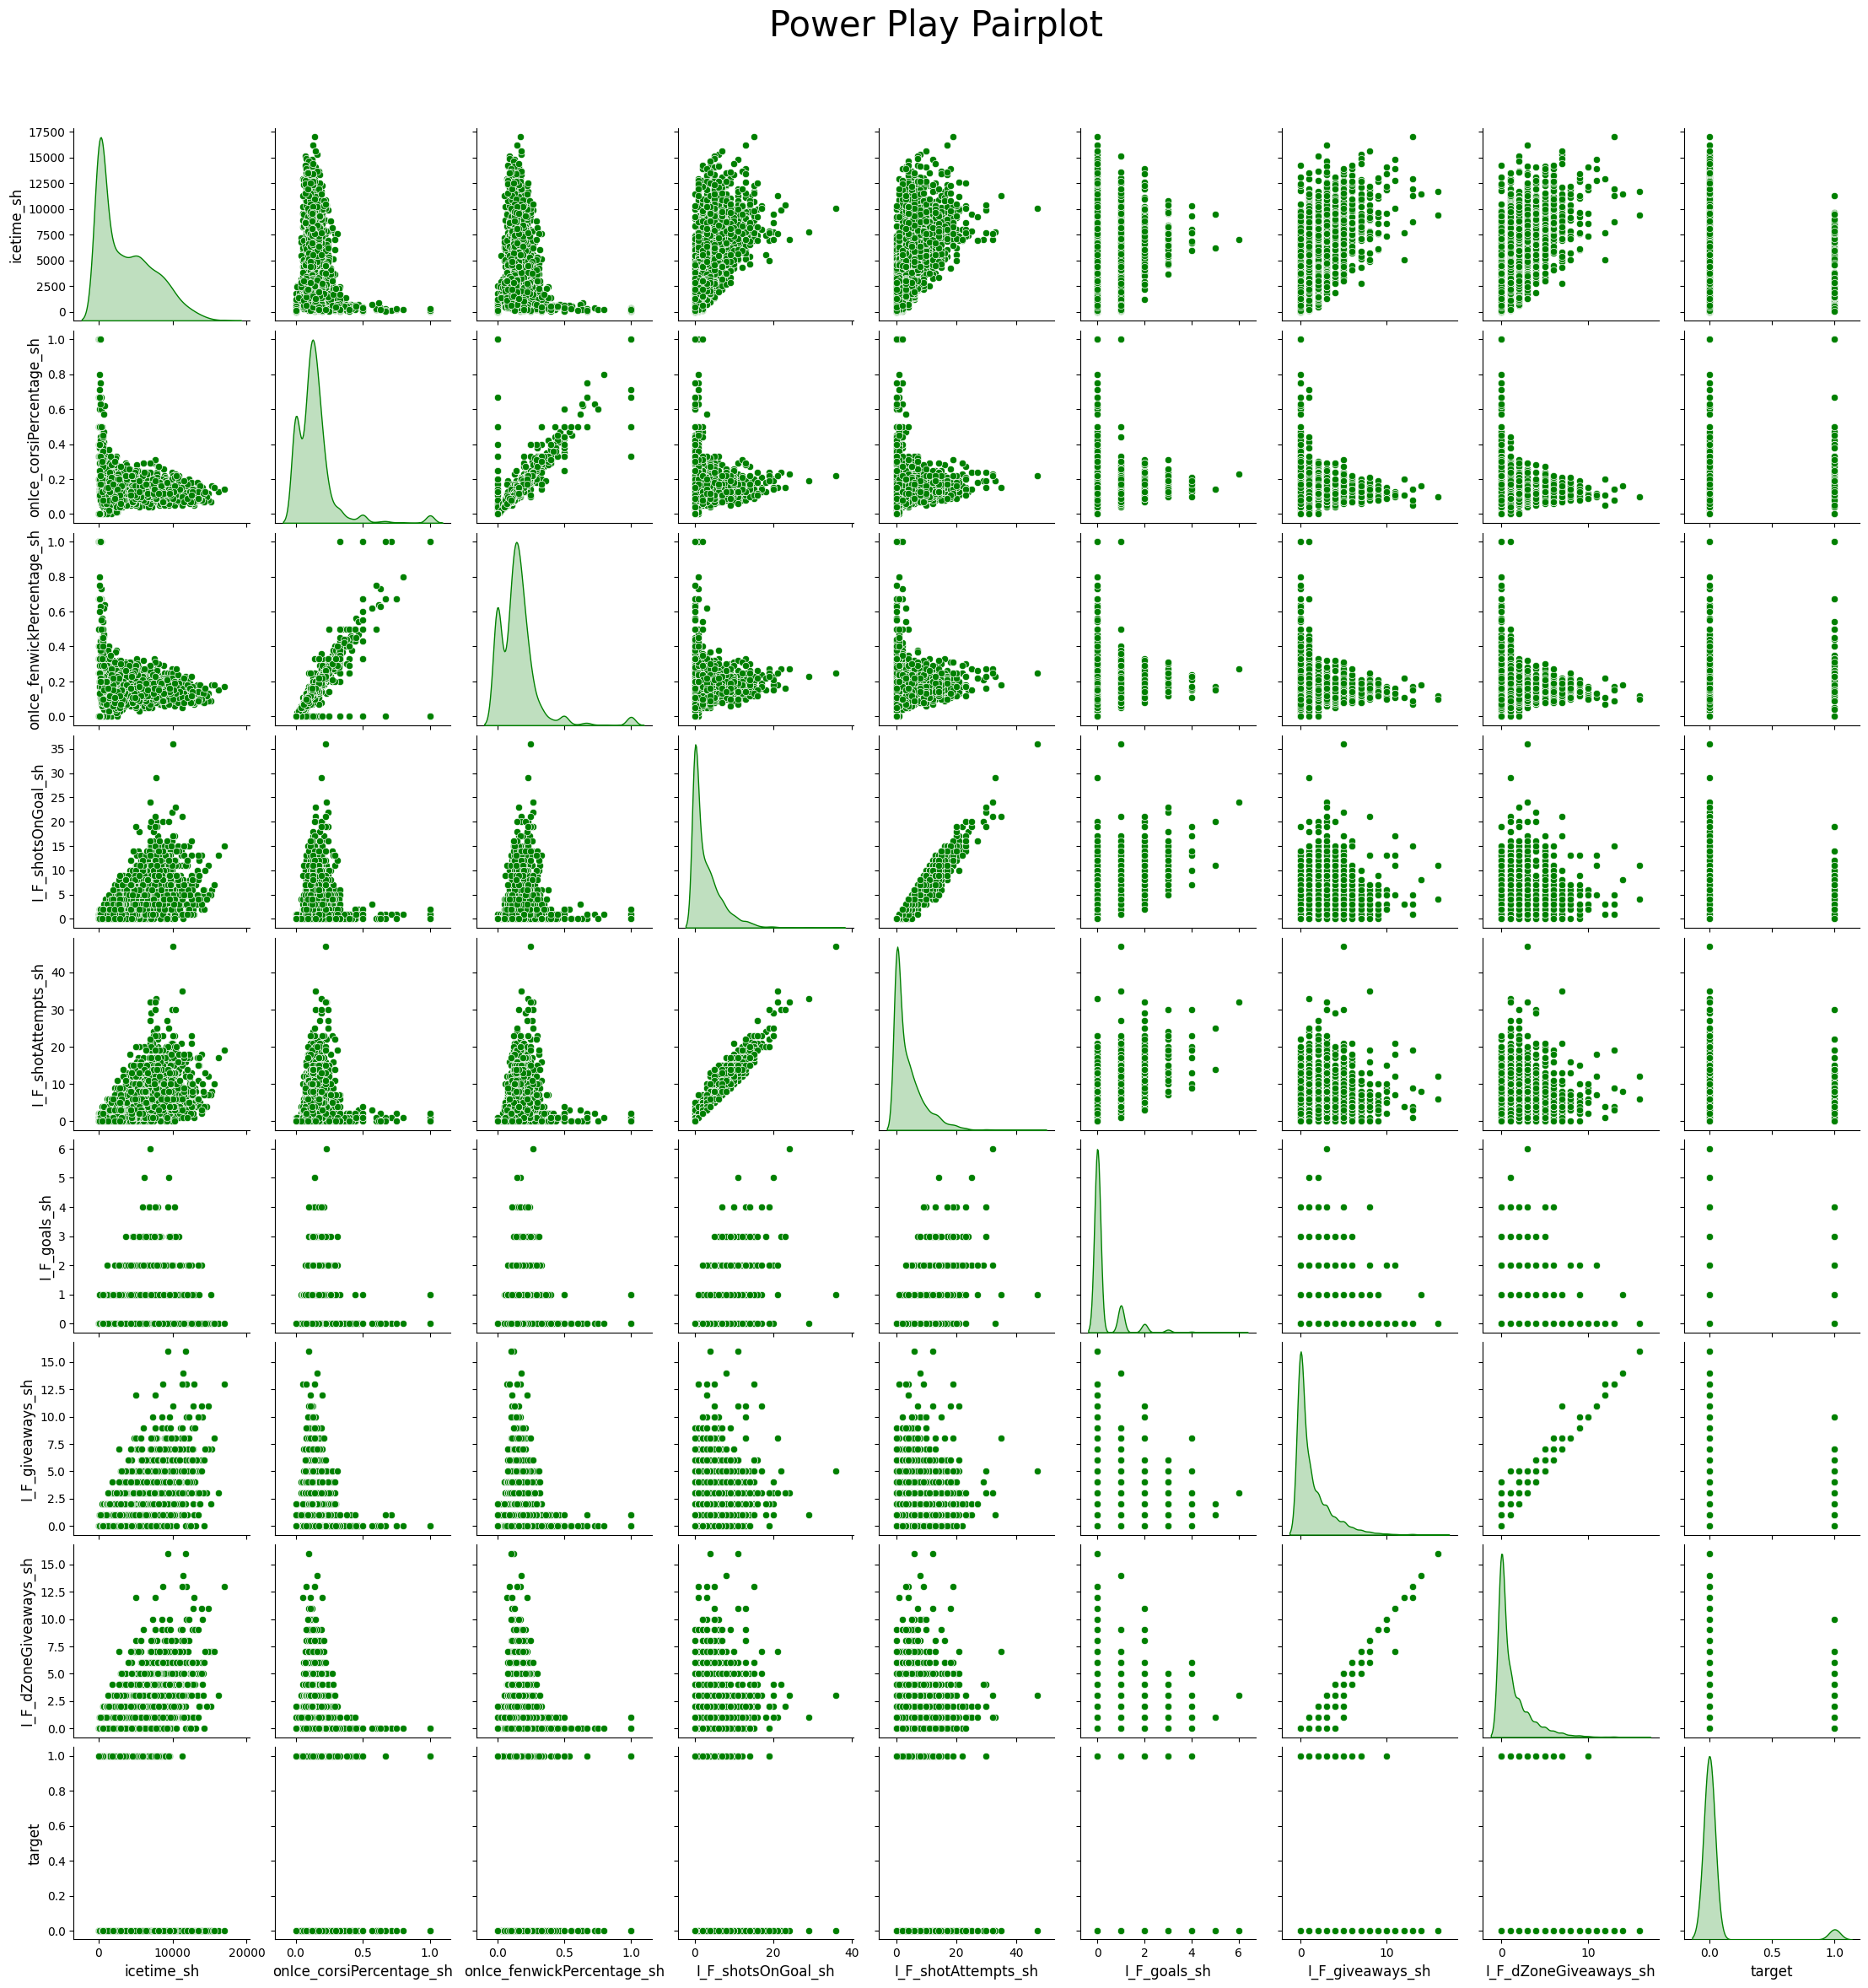

In [81]:

# Select columns
indx_5on5 = [6,7,8,13,14,15,19,20,66]
indx_5on4 = [20+6,20+7,20+8,20+13,20+14,20+15,20+19,20+20,66]
indx_4on5 = [40+6,40+7,40+8,40+13,40+14,40+15,40+19,40+20,66]

es = df.iloc[:, indx_5on5].copy()  # Add .copy() to avoid modifying a slice
pp = df.iloc[:, indx_5on4].copy()  # Add .copy() to avoid modifying a slice
sh = df.iloc[:, indx_4on5].copy()  # Add .copy() to avoid modifying a slice


# Replace inf/-inf with NaN, then fill NaN with 0 (or another value)
es = es.replace([np.inf, -np.inf], np.nan)  # Avoid inplace=True warning
es = es.fillna(0)  # Ensure all NaN are replaced

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # create the pair plot even-strength
    viz = sns.pairplot(
        data = es
        , diag_kind = 'kde'
    )
    
    viz.fig.suptitle(
        'Even-Strength Pairplot' 
        , fontsize = 30
        , y = 1.05
    )
    
    for ax in viz.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize = 12)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 12)

    # create the pair plot power play
    viz = sns.pairplot(
        data = pp
        , diag_kind = 'kde'
        , plot_kws={'color': 'orange'}
        , diag_kws={'color': 'orange'}
    )
    
    viz.fig.suptitle(
        'Power Play Pairplot' 
        , fontsize = 30
        , y = 1.05
    )
    
    for ax in viz.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize = 12)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 12)

    # create the pair plot short handed
    viz = sns.pairplot(
        data = sh
        , diag_kind = 'kde'
        , plot_kws={'color': 'green'}
        , diag_kws={'color': 'green'}
    )
    
    viz.fig.suptitle(
        'Power Play Pairplot' 
        , fontsize = 30
        , y = 1.05
    )
    
    for ax in viz.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize = 12)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 12)

### EDA Results and Analysis
The pair plots clearly show some multicollinearity between features. While collinearity appears obvious, I can't get a good sense of any feature importance from these plots; we'll try extracting some feature importance in our models. Returning to multicollinearity, of particular note are Corsi-Fenwick, shots on goal-shots attempted, and giveaways-defensive zone giveaways; these seem to hold for all game situations. Before doing any model training we will remove some of these features. Developing models with so many feature definitely makes this stage of our project more challenging and complex. An additional unforeseen challenge was interpreting  the sparsity of some of the variables in the special teams chunks.

## Models
I begin the modeling process by removing some of the collinearity discovered. Then I fit XGBoost, Random Forest and Lasso Logistic Regression models. I will use the results from those to do additional feature analysis. I used the scikit-learn library from python extensively for model preparation, fitting, and evaluation.

I selected these models for a couple reasons. XGBoost and Random Forest can yield good classification results with the added benefit of using random features in the training process. This helps mitigate some of the multicollinearity we discovered above-- while I took steps to reduce multicollinearity by eliminating certain features, this will help even further. I also selected lasso logistic regression, for its ability to do feature selection. Ultimately I'm interested in what features show the most predictive power, so using the feature importance methods for the tree based models, and seeing what features the lasso regression selects, will be vital in this analysis.

In [82]:
remove_more = [
    'onIce_fenwickPercentage'
    , 'onIce_fenwickPercentage_pp'
    , 'onIce_fenwickPercentage_sh'
    , 'I_F_shotAttempts'
    , 'I_F_shotAttempts_pp'
    , 'I_F_shotAttempts_sh'
    , 'I_F_giveaways'
    , 'I_F_giveaways_pp'
    , 'I_F_giveaways_sh'
    , 'OnIce_A_shotAttempts'
    , 'OnIce_A_shotAttempts_pp'
    , 'OnIce_A_shotAttempts_sh'
]
df = df.drop(columns = remove_more)

# drop Id, season, name, team, and position columns
df = df.drop(columns = ['playerId', 'season', 'name', 'team', 'position'])

### Prepare the Data and Models
To prepare the data I will split it into training and testing sets, 80% for training, 20% for testing. These sets will be random but seeded for reproducibility. Any cross-validation for hyperparameter optimization will be done only on the test set. Additionally, the metric I optimized for these grid searches was ROC-AUC. I wanted a measure that balanced the true positive rate and false positive rate because of the imbalance in the target class. Any cross validation procedures will use 5-folds.
  
Once, a cross-validation was run, I reset the hyperparameters to narrow the focus to even better hyperparameters. I only included the final iteration of cross-validation in this notebook. After doing a grid search on these models to find the best hyperparameters, I fit the models with the best sets of variables.

In [83]:
# train test split
X = df.drop(columns = ['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 90)


In [84]:
# optimize xgboost 

# initialize xgboost classifier
xgb_model = xgb.XGBClassifier(
    use_label_encoder = False
    , eval_metric = 'logloss'
    , random_state = 90
)

xgb_grid_dict = {
    'n_estimators': [100, 150, 200]
    , 'max_depth': [1,2,3]
    , 'learning_rate': [0.001, 0.01, 0.1]
}

xgb_grid_search = GridSearchCV(
    estimator = xgb_model
    , param_grid = xgb_grid_dict
    , scoring = 'roc_auc'
    , cv = 5
    , n_jobs = -1
    , verbose = 1
).fit(X_train, y_train)

print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best training ROC-AUC score: {xgb_grid_search.best_score_}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150}
Best training ROC-AUC score: 0.915770150989705


In [85]:
# optimize random forest

rf_model = RandomForestClassifier(random_state = 90)

rf_grid_dict = {
    'n_estimators': [300, 400, 500]  
    , 'max_depth': [7, 8, 9]   
    , 'min_samples_split': [2, 5]   
    , 'min_samples_leaf': [1, 2, 4]
    , 'max_features': ['sqrt']  
}

rf_grid_search = GridSearchCV(
    estimator = rf_model
    , param_grid = rf_grid_dict
    , scoring = 'roc_auc'
    , cv = 5
    , n_jobs = -1
    , verbose = 1
).fit(X_train, y_train)

print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best training ROC-AUC score: {rf_grid_search.best_score_}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Best training ROC-AUC score: 0.9140415492502898


In [86]:
# optimize lasso regression

lasso_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 90)

lasso_grid_dict = {
    #'C': np.logspace(-4,2)
    'C' : np.logspace(-1,0)
}

lasso_grid_search = GridSearchCV(
    estimator = lasso_model
    , param_grid = lasso_grid_dict
    , scoring = 'roc_auc'
    , cv = 5
    , n_jobs = -1
    , verbose = 1
).fit(X_train, y_train)

print(f"Best parameters: {lasso_grid_search.best_params_}")
print(f"Best training ROC-AUC score: {lasso_grid_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 0.44984326689694454}
Best training ROC-AUC score: 0.918847051278726


### Best Model Fits
Now that I know the best hyperparameters for the models, I train them on the entire test sets (above used 5-fold cross validation on just the test sets). I then compute the Receiver Operating Characteristic Area Under the Curve, and precision for these models. I chose ROC-AUC because of how it balances the true positive rate and false positive rate, and precision because of the imbalance in our target class-- I'm more interested in reducing false positives than reducing false negatives.

In [87]:
# train models with the best parameters

# xgboost
xgb_model = xgb.XGBClassifier(
    use_label_encoder = False
    , eval_metric = 'logloss'
    , random_state = 90
    , **xgb_grid_search.best_params_   # pull in the best parameters from the cross validation
).fit(X_train, y_train)

# make xgboost predictions
xgb_pred = xgb_model.predict_proba(X_test)


# random forest
rf_model = RandomForestClassifier(
    random_state = 90
    , **rf_grid_search.best_params_   
).fit(X_train, y_train)

# make random forest predictions
rf_pred = rf_model.predict_proba(X_test)


# lasso
lasso_model = LogisticRegression(
    penalty = 'l1'
    , solver = 'liblinear'
    , random_state = 90
    , **lasso_grid_search.best_params_   
).fit(X_train, y_train)

# make lasso predictions
lasso_pred = lasso_model.predict_proba(X_test)


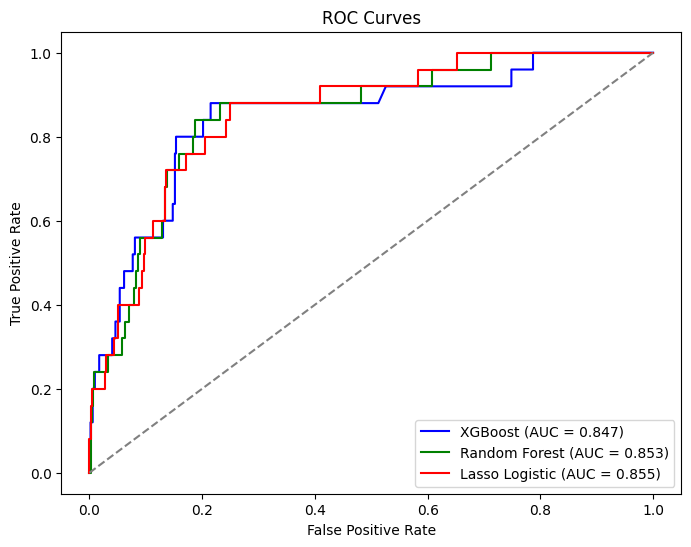

In [88]:
# plot the ROC curves

# Create a figure
plt.figure(figsize=(8, 6))

# Function to plot ROC curves
def plot_roc_curve(model_name, y_true, y_pred_proba, color):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])  # Get FPR, TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=color, label=f"{model_name} (AUC = {roc_auc:.3f})")  # Plot with AUC in legend

# Plot ROC curves for each model
plot_roc_curve("XGBoost", y_test, xgb_pred, 'blue')
plot_roc_curve("Random Forest", y_test, rf_pred, 'green')
plot_roc_curve("Lasso Logistic", y_test, lasso_pred, 'red')

# Plot diagonal line (random chance)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")

# Show the plot
plt.show()

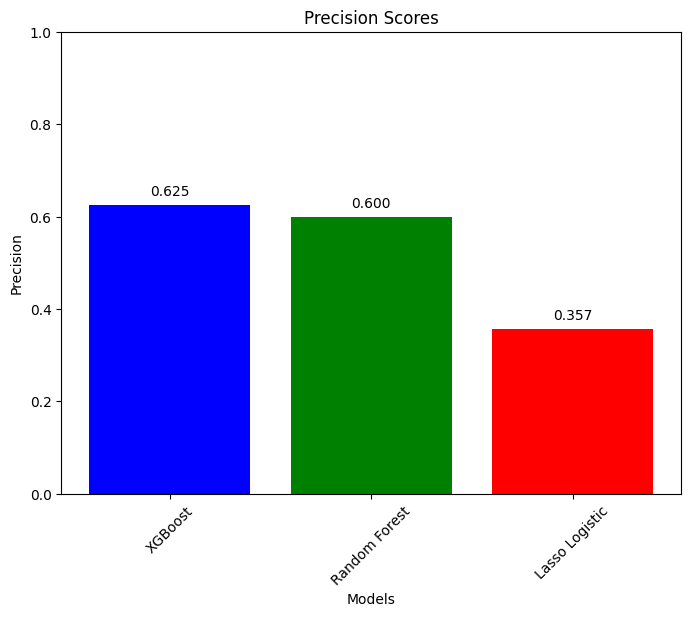

In [89]:
# plot precision bar charts

xgb_precision = precision_score(y_test, xgb_model.predict(X_test))
rf_precision = precision_score(y_test, rf_model.predict(X_test))
lasso_precision = precision_score(y_test, lasso_model.predict(X_test))

model_names = ["XGBoost", "Random Forest", "Lasso Logistic"]
precision_scores = [xgb_precision, rf_precision, lasso_precision]

# plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, precision_scores, color=['blue', 'green', 'red'])
plt.xlabel("Models")
plt.ylabel("Precision")
plt.title("Precision Scores")
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.xticks(rotation=45)  # Rotate labels if needed

# Add precision score labels on top of bars
for i, score in enumerate(precision_scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center')

# Show the plot
plt.show()

### Results
Initially, the ROC-AUC results encouraged me. The models seemed to do a good job of distinguishing between positive and negative cases. However, when I evaluated the precision of these models, I see that they struggle to accurately predict the positive class, All-Star Game selection. I looked into the actual predicted probabilities being made and discovered that the XGBoost and Random Forest models rarely assigned a probability above 0.50. The lasso regression was more generous, but this led to far more false positives as you can see in the sensitivity rate displayed above.

The ROC-AUC values looked so good because they don't consider a prediction threshold, that metric adjusts the threshold to calculate the true positive and false positive rates. The precision doesn't have this luxury. I could have set a threshold value to consider positive cases only above that threshold, but because the predicted probabilities of the tree based models weren't very high, it would only really affect the precision of the lasso model. 

### Feature Importance
Because the predicted probabilities of the random forest model were so low, and the lasso regression showed too many false positives, I decided to review the feature importance for only the XGBoost model. The python xgb library makes this easy to review with only a few lines of code. I evaluated both the weight and gain of the fitted model.

The weight of the features indicates how many times the XGBoost model used the feature to split on. The gain shows how much the model's accuracy improved with the inclusion of the feature. The weight and gain of the features in this model has significant overlap. I will now refit the XGBoost model with only the top 20 features from weight or gain. Let's see if this gives us better performance, or a different list of top features.

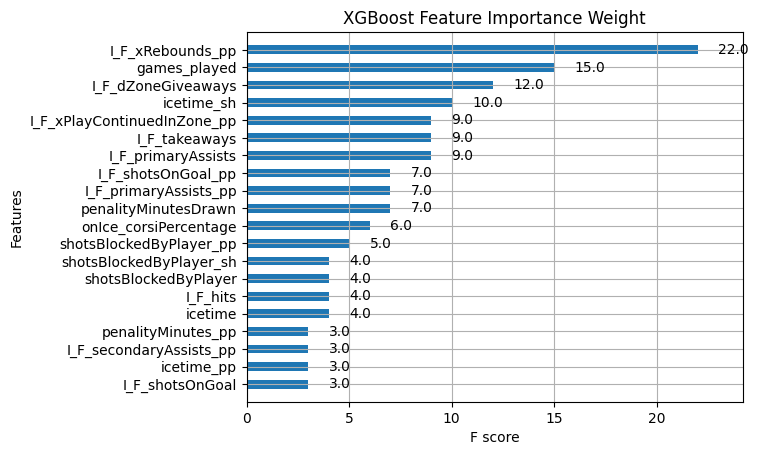

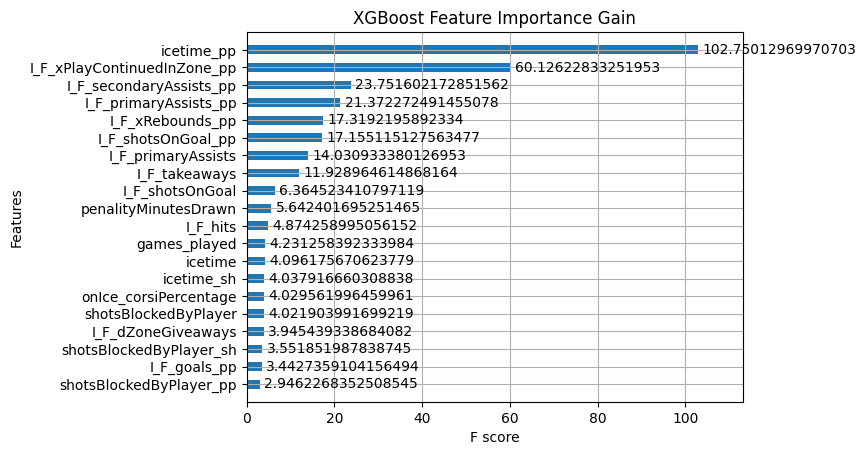

In [96]:
# xgboost feature importance

xgb.plot_importance(
    xgb_model
    , importance_type = 'weight'
    , max_num_features = 20
    , height = 0.5)
plt.title('XGBoost Feature Importance Weight')
plt.show()

xgb.plot_importance(
    xgb_model
    , importance_type = 'gain'
    , max_num_features = 20
    , height = 0.5)
plt.title('XGBoost Feature Importance Gain')
plt.show()

In [125]:
# extract weight and gain features
weight_importance = xgb_model.get_booster().get_score(importance_type='weight')
gain_importance = xgb_model.get_booster().get_score(importance_type='gain')

# put top 20 from each into a set
sorted_weight = sorted(weight_importance.items(), key=lambda x: x[1], reverse=True)[:20]
sorted_gain = sorted(gain_importance.items(), key=lambda x: x[1], reverse=True)[:20]

feature_set = set()

for item in sorted_weight:
    feature_set.add(item[0])

for item in sorted_gain:
    feature_set.add(item[0])

# convert the set to a list
feature_set = list(feature_set)


In [147]:
# fit new xgboost model

# need to update train and test sets
X_train_new = X_train[feature_set]
X_test_new = X_test[feature_set]

# initialize xgboost classifier
xgb_model_new = xgb.XGBClassifier(
    use_label_encoder = False
    , eval_metric = 'logloss'
    , random_state = 90
)

xgb_grid_dict = {
    'n_estimators': [400, 600]
    , 'max_depth': [1,2,3]
    , 'learning_rate': [0.01, 0.05]
}

xgb_grid_search_new = GridSearchCV(
    estimator = xgb_model_new
    , param_grid = xgb_grid_dict
    , scoring = 'roc_auc'
    , cv = 5
    , n_jobs = -1
    , verbose = 1
).fit(X_train_new, y_train)

print(f"Best parameters: {xgb_grid_search_new.best_params_}")
print(f"Best training ROC-AUC score: {xgb_grid_search_new.best_score_}")

xgb_model_new = xgb.XGBClassifier(
    use_label_encoder = False
    , eval_metric = 'logloss'
    , random_state = 90
    , **xgb_grid_search_new.best_params_
).fit(X_train_new, y_train)

xgb_pred_new = xgb_model_new.predict_proba(X_test_new)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 600}
Best training ROC-AUC score: 0.9191294227259112


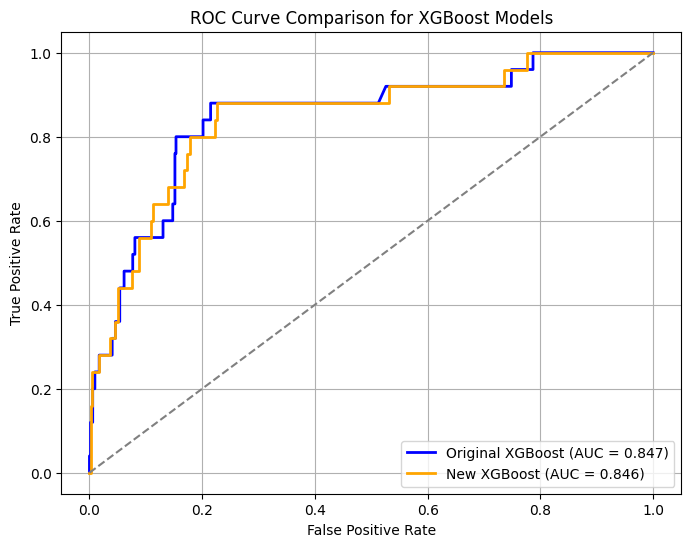

In [152]:

# Calculate ROC curve and AUC for the original XGBoost model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate ROC curve and AUC for the new XGBoost model
fpr_xgb_new, tpr_xgb_new, _ = roc_curve(y_test, xgb_pred_new[:,1])
roc_auc_xgb_new = auc(fpr_xgb_new, tpr_xgb_new)

# Plot both ROC curves together
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'Original XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot(fpr_xgb_new, tpr_xgb_new, color='orange', lw=2, label=f'New XGBoost (AUC = {roc_auc_xgb_new:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for XGBoost Models')
plt.legend(loc="lower right")
plt.grid(True)

### Reduced Features XGBoost
The reduced feature XGBoost model shows almost identical AUC; original: 0.847, new: 0.846. I'm confident in sticking with the original fit containing all of the features. Let's review again the top five features for model weight and gain.

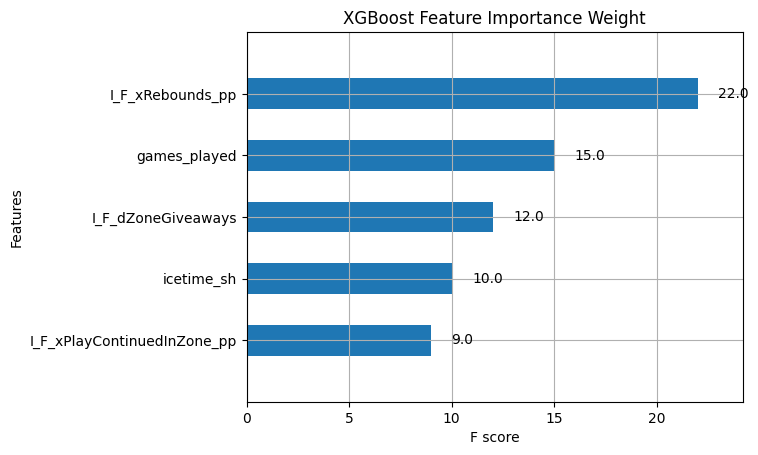

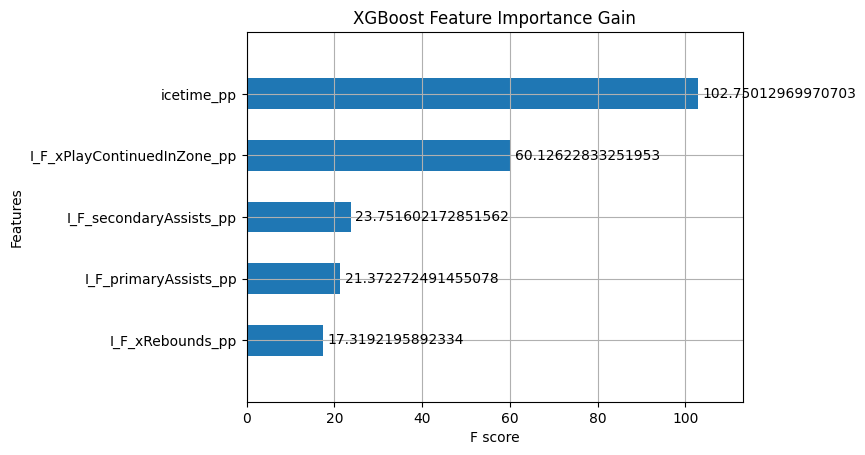

In [151]:
# xgboost feature importance

xgb.plot_importance(
    xgb_model
    , importance_type = 'weight'
    , max_num_features = 5
    , height = 0.5)
plt.title('XGBoost Feature Importance Weight')
plt.show()

xgb.plot_importance(
    xgb_model
    , importance_type = 'gain'
    , max_num_features = 5
    , height = 0.5)
plt.title('XGBoost Feature Importance Gain')
plt.show()

### Summary of Results
I fit three classification models to predict All-Star Game selection-- XGBoost, Random Forest, and Lasso Regression. All three models showed promise when looking at the ROC-AUC values and ROC curves. However, because the predicted probabilities of these models were so low, the precision metrics didn't perform particularly well for any of the models; I attribute this predominantly to the imbalance in target class. I decided to move forward with the XGBoost for exploring feature importance.

With an initial list of import features by weight and gain, I tried refitting the model with reduced features. This refit didn't improve our model. In the cell above you can see the important model features, I also include them in a table here with more reader friendly names for the variables:
| Important Features              |
|----------------------|
| Power Play Shots with Rebound      |
| Games Played |
| Defensive Zone Turnovers |
| Power Play Ice Time |
| Short Handed Ice Time |
| Power Play Shots Stay In Zone |
| Secondary Assists |
| Primary Assists     |

A couple surprises in this list! The model doesn't predict goals scored to be significant contributor to All-Star Game selection. I also think short handed ice time is interesting to see here. I would expect that power plays and offense generation to dominate, but it actually seems like team contributions provide more predictive value than individual accomplishments like goals.



## Conclusion
I gained some interesting insights through this project. While the models didn't perform quite as well as I hoped, I see some room for improvement. The biggest takeaway was the need for a robust and thorough cleaning process; multicollinearity can be a real insidious problem when fitting classification models. Additionally, creating new columns for game situations added some complexity to the modeling process.

### Findings
I set out to determine if we could predict All-Star Game inclusion based on a players' season statistics, and to see what features contributed the most to those selections. The tree based models did not enthusiastically predict the positive class, the predicted probabilities were overwhelmingly near the 0.5 mark, meaning just better than half odds. The lasso regression showed more confidence in predictions, but this led to an inflated false positive rate. Overall, I was a little disappointed with the performance. To our second point, finding the important features, I'm more optimistic. The XGBoost model showed the most promise here with the best combination of ROC-AUC and precision. Again, I picked these metrics to account for an imbalanced target class. I think our performance issues stem primarily from an imbalanced target class and additional unaccounted for multicollinearity in the feature set.

### Improvements
There are some obvious initial limitations to this model. I used season-long statistics when All-Star Game selection occurs around the half-way point of an NHL season. Aggregating stats to the time in the season before selection could help improve the model. Additionally, a more robust analysis of multicollinearity could help. I only explored collinearity within game situation types; meaning, I only looked for problems within the 5on5 situation, the 5on4 situation, and the 4on5 situation. Expanding this search to look for multicollinearity across game situations could help. I didn't notice anything particularly troubling about possible overfitting; but, I think expanding the number of years, and thus increasing our sample size could help. Keep in mind, I needed to remove an entire year's worth of data because there was no All-Star Game that year. Finally, I would consider training the models using one the 'all' situation instead of separating the game situations into their own columns. This would help refine our space of features and be able to handle any issues there better.

### Recommendations
Based on the findings of this model. Here are the recommendations I would make to players seeking to get an edge in All-Star Game selection.
1. Get on the Power Play or Penalty Kill: These special teams unit stats contributed much more than I expected.
2. Make shots that generate rebounds: Goalies in the NHL are so good, it's hard to beat them cleanly. Get shots to rebound of the goalie to give your teammates a chance to score easy goals.
3. Make the pass: Assists, both primary and secondary, contribute more to selection than goals. Additionally, those shots with rebounds count as assists. So if you can't make a clean pass, pass it off the goalie :)

### Future Work
In the future I would be interested in doing an analysis based on player position. How does player position interact with other features. The tree models would capture some of this interaction, but an intentional interaction analysis would be interesting to explore. I would also be interested to see how on-ice off-ice splits in statistics contribute to selection. I think looking at these splits could illuminate how much better a player is relative to his teammates.



## References
MoneyPuck. (n.d.). Skaters 2019-2020. Retrieved Feb. 27, 2025, from https://moneypuck.com/data.htm

MoneyPuck. (n.d.). Skaters 2020-2021. Retrieved Feb. 27, 2025, from https://moneypuck.com/data.htm

MoneyPuck. (n.d.). Skaters 2021-2022. Retrieved Feb. 27, 2025, from https://moneypuck.com/data.htm

MoneyPuck. (n.d.). Skaters 2022-2023. Retrieved Feb. 27, 2025, from https://moneypuck.com/data.htm

MoneyPuck. (n.d.). Skaters 2023-2024. Retrieved Feb. 27, 2025, from https://moneypuck.com/data.htm

2019 National Hockey League All-Star Game. Retrieved Feb. 27, 2025,
Wikipedia. https://en.wikipedia.org/wiki/2019_National_Hockey_League_All-Star_Game

2020 National Hockey League All-Star Game. Retrieved Feb. 27, 2025,
Wikipedia. https://en.wikipedia.org/wiki/2020_National_Hockey_League_All-Star_Game

2022 National Hockey League All-Star Game. Retrieved Feb. 27, 2025,
Wikipedia. https://en.wikipedia.org/wiki/2022_National_Hockey_League_All-Star_Game

2023 National Hockey League All-Star Game. Retrieved Feb. 27, 2025,
Wikipedia. https://en.wikipedia.org/wiki/2023_National_Hockey_League_All-Star_Game

